In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
dir_path='/kaggle/input/animefacedataset/images'
# dir_path='/kaggle/input/'
count =0
# for path in os.listdir(dir_path):
#     # check if current path is a files
#     if os.path.isfile(os.path.join(dir_path, path)):        
#         count += 1
print("image count:{}".format(count))
input_path='/kaggle/input/anime-face-discriminator-model-data/'

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(f"dir:{dirname}")
#     for filename in filenames:
#         if dirname =='/kaggle/input/anime-profile-picture-generator':
#             print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

image count:0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import torchvision

train_path = '/kaggle/input/animefacedataset'

In [3]:
image_count=0;
from PIL import Image
for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        image = Image.open(os.path.join(dir_path, path))
        print("{}".format( np.asarray(image).shape))
        image_count+=1
        if(image_count>10):
            break

(63, 63, 3)
(81, 81, 3)
(97, 97, 3)
(100, 100, 3)
(68, 68, 3)
(111, 111, 3)
(102, 102, 3)
(83, 83, 3)
(82, 82, 3)
(56, 56, 3)
(105, 105, 3)


In [4]:
train_transforms = transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform = train_transforms)

In [6]:
batch_size= 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

torch.Size([64, 3, 64, 64])


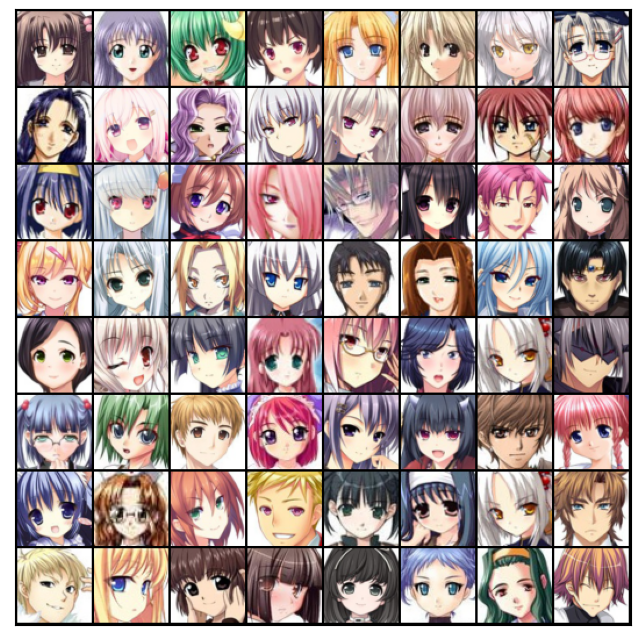

In [8]:
images=next(iter(train_loader))
print(images[0].shape)
# img_tensor = torch.Tensor(images)
# max_pix = torch.Tensor([-np.Inf,-np.Inf,-np.Inf])
# min_pix = torch.Tensor([np.Inf,np.Inf,np.Inf])
# for images in train_loader:
#     test_max= torch.Tensor(torch.max(images[0].permute(1,0,2,3),1)[0])
#     test_min= torch.Tensor(torch.min(images[0].permute(1,0,2,3),1)[0])
#     print(test_max)
#     print(test_min)
#     break
#     max_pix = torch.max(torch.Tensor([test_max, max_pix]),dim=1)[0].max(dim=1)
#     min_pix = torch.min(torch.Tensor([test_min, min_pix]),dim=1)[0].min(dim=1)
# print(f"max_pix:{max_pix}")
# print(f"min_pix:{min_pix}")
# print(torch.min(test,dim=1)[0].min(dim=1))
show_batch(images)

In [9]:
TRAIN_ON_GPU = torch.cuda.is_available()

def to_device(tensor):
    if TRAIN_ON_GPU:
        return tensor.cuda()
    return tensor.cpu()

In [11]:
# def get_mean_std_of_imaged(dataloader):
#     total_image_count=0
#     batch_means = []
#     batch_image_count = []
#     batch_stds = []
#     batch_sums = []
#     i=0
#     for images, _ in dataloader:
#         images  = images.cuda()
#         image_count_in_batch = images.size(0)
#         image= images.permute(1,0,2,3)
#         # print("converted image size:{}".format(image.size()))
#         batch_means.append(to_device(image.reshape(3,-1).mean(1)))
#         batch_stds.append(to_device(image.reshape(3,-1).std(1)))
#         batch_sums.append(to_device(image.reshape(3,-1).sum(1)))
#         batch_image_count.append(to_device(torch.Tensor([image_count_in_batch])))

#         total_image_count+=image_count_in_batch
#         # print("{},{},{}".format(batch_means,batch_stds,batch_sums))
#         # print("{}".format(batch_image_count))
#         # if(i==2):
#         #     break;
#         # i+=1
#     means=torch.stack(batch_means)
#     stds=torch.stack(batch_stds)
#     sums=torch.stack(batch_sums)
#     image_counts = torch.stack(batch_image_count)
    
#     total_mean = torch.mul(means,image_counts).sum(0)/total_image_count
#     total_std = torch.mul(torch.square(stds), image_counts) - (torch.square(means)*image_counts)
#     total_std = total_std + 2* torch.mul(sums,means)
#     total_sum = sums.sum(0)
#     # total_std = torch.sqrt(torch.square(total_std.sum(0) - torch.Tensor([total_mean, total_mean, total_mean]))/total_image_count)
#     total_std = total_std.sum(0)
#     total_std = total_std + torch.square(total_mean)*total_image_count - 2* torch.mul(total_mean,total_sum)
#     total_std = torch.sqrt(total_std/total_image_count)
#     # print("means:{}, image_count:{}".format(means, image_counts))
#     # print("total_mean:{}".format(total_mean))
#     # print("stds:{}, image_count:{}".format(stds, image_counts))
#     # print("total_std:{}".format(total_std))
#     # cal = torch.square(batch_stds)*batch_image_count
#     # print(cal)
#     # std = cal
#     return torch.stack([total_mean, total_std])
        

In [ ]:
# mean_std= get_mean_std_of_imaged(train_loader)
# mean = mean_std[0]
# std = mean_std[1]
# print("{},{}".format(mean,std))
# mean =torch.tensor([0.6869, 0.5878, 0.5718])
# std = torch.tensor([1.4348, 1.3272, 1.3220])

In [ ]:
# print("{},{}".format(mean,std))

In [12]:
train_transforms = transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform = train_transforms)

In [19]:
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size

In [20]:
batch_size= 64
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,[train_set_size,valid_set_size])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)

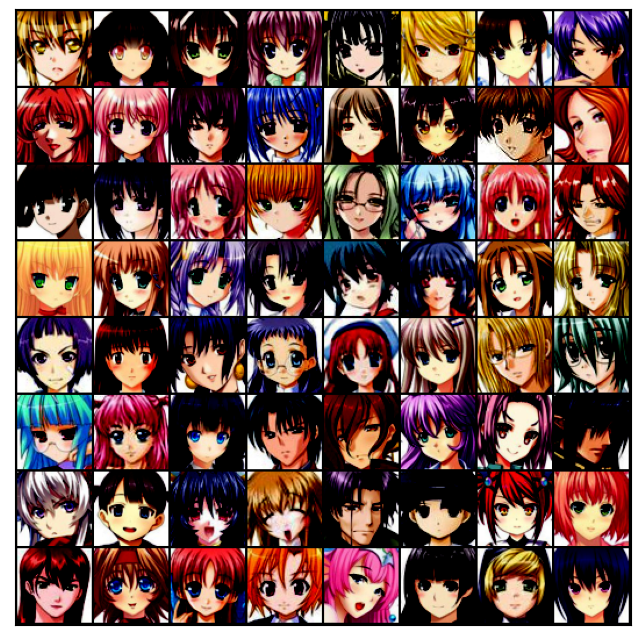

In [21]:
images_batch = next(iter(train_loader))
show_batch(images_batch)

In [10]:
from torch import nn, optim
from torch.autograd import Variable

In [43]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.leaky_relu = nn.LeakyReLU(0.05)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.1)

        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.conv1(x)))  # (Batch, 8, 32, 32)
        x = self.pool(self.leaky_relu(self.conv2(x)))  # (Batch, 16, 16, 16)
        x = self.pool(self.leaky_relu(self.conv3(x)))  # (Batch, 32, 8, 8)

        x = self.flatten(x)  # (Batch, 32*8*8)
        
        x = self.dropout(self.leaky_relu(self.fc1(x)))  # (Batch, 256)
        x = self.dropout(self.leaky_relu(self.fc2(x)))  # (Batch, 512)
        
        x = self.sigmoid(self.fc3(x))  # (Batch, 1)
        return x
    
    def feature_extractor(self, x):
        """Extract features from an intermediate layer."""
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))        
        return x  # Return feature map instead of classification output
        

def feature_matching_loss(discriminator, real_images, fake_images):
    real_features = discriminator.feature_extractor(real_images)
    fake_features = discriminator.feature_extractor(fake_images)
    # return 0
    return torch.nn.functional.mse_loss(fake_features, real_features)

discriminator_model = Discriminator()
# discriminator_model = nn.Sequential(
#     # 64*3*64*64
#     nn.Conv2d(3,8,3,stride=1,padding=1),
#     nn.LeakyReLU(0.05),    
#     nn.MaxPool2d(2,2),

#     # 64*8*32*32
#     nn.Conv2d(8,16,3,stride=1,padding=1),
#     nn.LeakyReLU(0.05),
#     nn.MaxPool2d(2,2),
    
#     # 64*32*16*16
#     nn.Conv2d(16,32,3,stride=1,padding=1),
#     nn.LeakyReLU(0.05),
#     nn.MaxPool2d(2,2),    
    
#     nn.Flatten(),
    
#     # 64*256*4*4
#     nn.Linear(32*8*8,256),
#     nn.LeakyReLU(0.05),
#     nn.Dropout(0.1),
    
#     nn.Linear(256,512),
#     nn.LeakyReLU(0.05),
#     nn.Dropout(0.1),
    
#     nn.Linear(512,1),    
#     nn.Sigmoid()
# )



In [42]:
latent_size=256
generator_model = nn.Sequential(
#4096 * 1 * 1
    
nn.ConvTranspose2d(latent_size,128,4,padding=0,stride=1),
nn.BatchNorm2d(128),
nn.LeakyReLU(),
    
#2048 * 4 * 4
nn.ConvTranspose2d(128,64,4,padding=1,stride=2),
nn.BatchNorm2d(64),
nn.LeakyReLU(),

#1024 * 8 * 8
nn.ConvTranspose2d(64,32,4,padding=1,stride=2),
nn.BatchNorm2d(32),
nn.LeakyReLU(),

#512 * 16 * 16
nn.ConvTranspose2d(32,16,4,padding=1,stride=2),
nn.BatchNorm2d(16),
nn.LeakyReLU(),

#256 * 32 * 32
nn.ConvTranspose2d(16,3,4,padding=1,stride=2),
# nn.BatchNorm2d(3),
nn.Tanh(),
# nn.ConvTranspose2d(8,3,4,padding=1,stride=2),
# nn.BatchNorm2d(3),
# nn.ReLU(),
)

In [50]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('assigning model to gpu')
    discriminator_model.cuda()
    generator_model.cuda()

assigning model to gpu


In [100]:
# if os.path.exists('discriminator_model.pth'):
#     os.remove('discriminator_model.pth')
# if os.path.exists('discriminator_losses.txt'):
#     os.remove('discriminator_losses.txt') 
# if os.path.exists('generator_model.pth'):
#     os.remove('generator_model.pth')
# if os.path.exists('generator_losses.txt'):
#     os.remove('generator_losses.txt')
# if os.path.exists('current_discriminator_model.pth'):
#     os.remove('current_discriminator_model.pth')
# if os.path.exists('current_generator_model.pth'):
#     os.remove('current_generator_model.pth')


In [71]:
discriminator_model_path='/kaggle/working/current_discriminator_model_latest.pth'
if os.path.exists(discriminator_model_path):
    print('loading discriminator model')
    discriminator_model_state = torch.load(discriminator_model_path)
#     print(discriminator_model_state)
    discriminator_model.load_state_dict(torch.load(discriminator_model_path))
#     discriminator_model.cuda()
    
generator_model_path='/kaggle/working/current_generator_model_latest.pth'
if os.path.exists(generator_model_path):
    print('loading generator model')
    generator_model_state = torch.load(generator_model_path)
    generator_model.load_state_dict(generator_model_state)
#     generator_model.cuda()
    


loading discriminator model
loading generator model


In [46]:
def show_generated_images(generated_images):
    grid_size = int(np.sqrt(batch_size))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(11,11))
    for i, ax in enumerate(axes.flatten()):
        img = generated_images[i].cpu().detach().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [47]:
min_generating_loss= np.Inf
min_generating_training_loss= np.Inf
min_train_loss = np.Inf

training_losses =[]
fake_train_losses =[]
validation_losses=[]
fake_validation_losses=[]
total_losses =[]
total_validation_losses=[]

generating_losses=[]
generating_validation_losses=[]

fake image:torch.Size([64, 3, 64, 64])
fake output:tensor([[1.4402e-03],
        [1.6223e-03],
        [6.4643e-04],
        [7.8553e-04],
        [2.5633e-04],
        [7.5233e-05],
        [2.5986e-03],
        [1.6431e-03],
        [1.6994e-04],
        [1.0633e-02],
        [3.3465e-03],
        [1.2554e-03],
        [1.6196e-04],
        [8.8966e-03],
        [1.2917e-03],
        [7.0202e-06],
        [6.6903e-04],
        [2.0494e-05],
        [1.2002e-02],
        [1.9785e-03],
        [1.7986e-03],
        [5.0831e-04],
        [8.1555e-04],
        [1.2961e-03],
        [1.7579e-03],
        [2.1670e-04],
        [8.1493e-04],
        [1.4309e-04],
        [6.2639e-05],
        [3.7653e-04],
        [2.5134e-04],
        [9.5700e-04],
        [1.4747e-04],
        [1.0795e-04],
        [2.1140e-03],
        [6.3721e-06],
        [5.2394e-05],
        [3.3908e-04],
        [5.9136e-03],
        [2.2384e-04],
        [1.1415e-04],
        [2.2838e-03],
        [4.5677e-03],
   

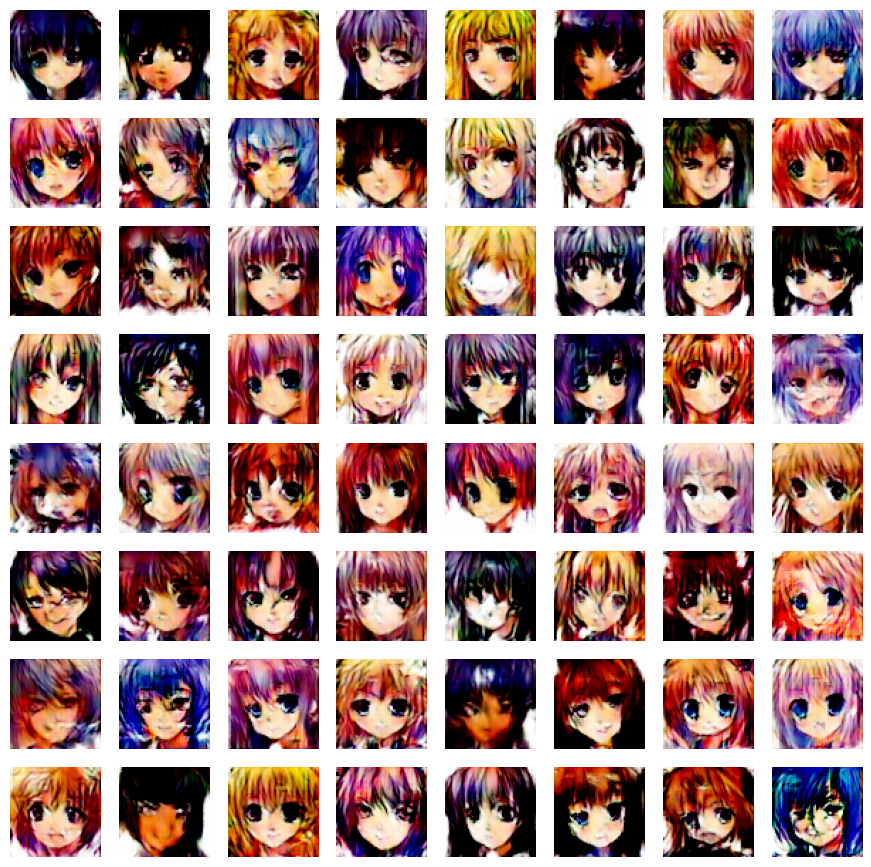

In [105]:
random_vector = torch.randn(batch_size,latent_size,1,1).clamp(-0.75,0.75)
# random_vector = torch.rand(batch_size,3,64,64)
# print(f"random_vector:{random_vector}")
generator_model.eval()
fake_images = generator_model(to_device(random_vector))
# real_images= next(iter(train_loader))
# print(f"real image:{real_images}")
fake_output = discriminator_model(to_device(fake_images))
# real_output = discriminator_model(real_images.to(dtype=torch.float))
print(f"fake image:{fake_images.shape}")
# print(f"real image:{real_images.shape}")
print(f'fake output:{fake_output}')                               
# print(f'real output:{real_output}')
generator_model.train()
# print(fake_images.size())

show_generated_images(fake_images)


In [ ]:
# exit(0)

In [30]:
def train_discriminator_batch(epoch, batch_num, images, discriminator_model, generator_model, criterion, optimizer, train=True):
    labels = to_device(torch.full((images.size(0), 1), 1.0))    
    images = to_device(images)

    random_vector = to_device(torch.randn(images.size(0), latent_size, 1, 1).clamp(-1, 1))
    fake_images = to_device(generator_model(random_vector))  # DO NOT detach here

    fake_labels = to_device(torch.full((images.size(0), 1), 0.0))

    if train:
        discriminator_model.train()
        optimizer.zero_grad()  # Reset gradients

    real_output = discriminator_model(images)
    # print(f"real_output requires_grad: {real_output.requires_grad}")  # Debugging
    train_loss = criterion(real_output, labels)

    if train:
        # print(f"train_loss requires_grad: {train_loss.requires_grad}")  # Debugging
        train_loss.backward(retain_graph=True)  # Retain graph for debugging

    fake_output = discriminator_model(fake_images)
    fake_train_loss = criterion(fake_output, fake_labels)

    if train:
        fake_train_loss.backward()  # Backprop for fake samples
        # for param in discriminator_model.parameters():
        #     if param.grad is not None:
        #         print(f"Gradients of discriminator parameter {param.shape}: {param.grad.norm()}")
        #     else:
        #         print('discriminator gradient none')

        optimizer.step()

    return train_loss.item() * images.size(0), fake_train_loss.item() * images.size(0)

def train_generator_batch(real_images,batch_size, latent_size,discriminator_model,generator_model,generator_optimizer,criterion,train_execution=True):
    random_vector = to_device(torch.randn(real_images.size(0),latent_size,1,1).clamp(-1,1) )
    fake_images = generator_model(random_vector)    
    fake_labels = to_device(torch.ones(real_images.size(0),1))

    if train_execution:
        generator_model.train()
        generator_optimizer.zero_grad()
    else:
        generator_model.eval()
        
    output = discriminator_model(fake_images)
    generator_loss = criterion(output,fake_labels)
    train_loss = generator_loss + 0.4 * feature_matching_loss(discriminator_model,to_device(real_images), fake_images)
    
    if train_execution:
        # print(f"generator train_loss requires grad:{train_loss.requires_grad}" )
        train_loss.backward()    
        generator_optimizer.step()
    return generator_loss.item() * real_images.size(0)

def record_epoch_loss(data_loader, loss,fake_loss, loss_list, fake_loss_list,total_loss_list, generator_loss, generating_loss_list):
    loss_list.append(loss)
    fake_loss_list.append(fake_loss)
    total_loss_list.append((loss + fake_loss))    
    generating_loss_list.append(generator_loss)

def write_discriminator_training_loss_file(filename, training_losses,fake_train_losses,total_losses,validation_losses,fake_validation_losses,total_validation_losses):
    with open(filename,'a') as loss_file:
        loss_file.writelines('\n')
        loss_file.writelines(str(training_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(fake_train_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(total_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(validation_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(fake_validation_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(total_validation_losses))
        

def write_generator_loss_file(filename,generating_losses,generating_validation_losses):
    with open(filename,'a') as loss_file:
        loss_file.writelines(str(generating_losses))
        loss_file.writelines('\n')
        loss_file.writelines(str(generating_validation_losses))



In [31]:
def train(epochs,optimizer_d,optimizer_g,criterion,discriminator_model,generator_model,loss_filename,generator_loss_filename): 
    global min_generating_loss
    global min_train_loss
    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0        
        fake_valid_loss=0.0   
        fake_train_loss=0.0
        generating_loss=0.0
        generating_valid_loss=0.0
        
        j=1
        print('training epoch:{}'.format(epoch))     

        for images,_ in train_loader:
#             print('discriminator batch training')
            
            batch_train_loss, batch_fake_train_loss=train_discriminator_batch(epoch,j,images, discriminator_model,generator_model,criterion,optimizer_d)
            train_loss +=batch_train_loss
            fake_train_loss +=batch_fake_train_loss
            # print(f"training loss:", train_loss, fake_train_loss )
            if j%4==0:
                generating_loss +=train_generator_batch(images,batch_size,latent_size,discriminator_model,generator_model ,optimizer_g,criterion)            
            
#             print('generator batch training')            
            j+=1
            
        j=1
        for images ,_ in valid_loader:
            batch_valid_loss, batch_fake_valid_loss = train_discriminator_batch(epoch,j,images, discriminator_model,generator_model,criterion,optimizer_d,False)
            valid_loss +=batch_valid_loss
            fake_valid_loss +=batch_fake_valid_loss
            if j%4==0:
                generating_valid_loss +=train_generator_batch(images,batch_size,latent_size,discriminator_model,generator_model ,optimizer_g,criterion,False)
            j+=1
            
        record_epoch_loss(train_loader, train_loss,fake_train_loss,training_losses,fake_train_losses,total_losses,generating_loss,generating_losses)
        record_epoch_loss(valid_loader, valid_loss,fake_valid_loss,validation_losses,fake_validation_losses,total_validation_losses,generating_valid_loss,generating_validation_losses)

        if (valid_loss+fake_valid_loss) < min_train_loss:
            print('train loss reduced from:{:.6f} ==> {:.6f}'.format(min_train_loss, valid_loss+fake_valid_loss))
            if (valid_loss+fake_valid_loss) == 0:
                print(f"exiting early due to loss collapse")
                break
            print('saving current model')
            torch.save(discriminator_model.state_dict(), 'discriminator_model.pth')
            min_train_loss = valid_loss+fake_valid_loss
            # for param in discriminator_model.parameters():
            #     if param.grad is not None:
            #         print(f'after min update Gradients of discriminator parameter {param.shape}: {param.grad.norm()}')
        else:
            for param in discriminator_model.parameters():
                if param.grad is not None:
                    print(f'Gradients of discriminator parameter {param.shape}: {param.grad.norm()}')
        
        if  generating_valid_loss < min_generating_loss:
            print('generator train loss reduced from:{:.6f} ==> {:.6f}'.format(min_generating_loss, generating_valid_loss))
            if generating_valid_loss == 0:
                print(f"exiting early due to generator loss collapse")
                break
            print('saving current generator model')
            torch.save(generator_model.state_dict(), 'generator_model.pth')
            min_generating_loss = generating_valid_loss
        else:            
            for param in generator_model.parameters():
                if param.grad is not None:
                    print(f'Gradients of generator parameter {param.shape}: {param.grad.norm()}')
            
    write_discriminator_training_loss_file(loss_filename,training_losses,fake_train_losses,total_losses,validation_losses,fake_validation_losses,total_validation_losses)
    write_generator_loss_file(generator_loss_filename,generating_losses,generating_validation_losses)

In [32]:
def parse_loss_file(filename):
    with open(filename,'r') as loss_file:
        lines = loss_file.readlines()
        loss_list_strings=[]
        string=[]
        for line in lines:
            line = line.strip()
            for char in line:
                if char=='[':
                    continue
                if char==']':
        #             print(''.join(string))
                    loss_list_strings.append(''.join(string))
                    string=[]
                    continue
                string.append(char)
#         print(loss_list_strings)
    return loss_list_strings


In [34]:
discriminator_loss_filename='/kaggle/working/discriminator_losses.txt'
if os.path.exists(discriminator_loss_filename):
    loss_list_strings=parse_loss_file(discriminator_loss_filename)

    training_losses = []
    fake_train_losses = []
    total_losses = []
    validation_losses = []
    fake_validation_losses=[]
    total_validation_losses=[]
    
    for i in range(int(len(loss_list_strings)/6)):
        training_losses += list(map(float,loss_list_strings[0+6*i].split(',')))
        fake_train_losses += list(map(float,loss_list_strings[1+6*i].split(',')))
        total_losses += list(map(float,loss_list_strings[2+6*i].split(',')))
        validation_losses += list(map(float,loss_list_strings[3+6*i].split(',')))
        fake_validation_losses+=list(map(float,loss_list_strings[4+6*i].split(',')))
        total_validation_losses+=list(map(float,loss_list_strings[5+6*i].split(',')))
    
    
    min_train_loss = np.min(validation_losses)
    min_validation_loss = np.min(fake_validation_losses)
    print(f"minimum validation loss:{np.min(min_validation_loss)}, {np.min(fake_validation_losses)}")
    print(len(total_validation_losses))

minimum validation loss:23.924615043855738, 23.924615043855738
168250


In [35]:
generator_loss_filename='/kaggle/working/generator_losses.txt'
if os.path.exists(discriminator_loss_filename):
    loss_list_strings = parse_loss_file(generator_loss_filename)
    generating_losses=[]
    generating_validation_losses=[]
    
    for i in range(int(len(loss_list_strings)/2)):
        generating_losses += list(map(float,loss_list_strings[i*2].split(',')))
        generating_validation_losses += list(map(float,loss_list_strings[i*2+1].split(',')))
    # print(len(generating_losses))
    # print(generating_losses[:10])
    min_generating_loss = np.min(generating_losses)
    min_validation_loss = np.min(generating_validation_losses)
    print(min_generating_loss)
    print(min_validation_loss)
    print(len(generating_losses))

52626.29613876343
8222.587013244629
168250


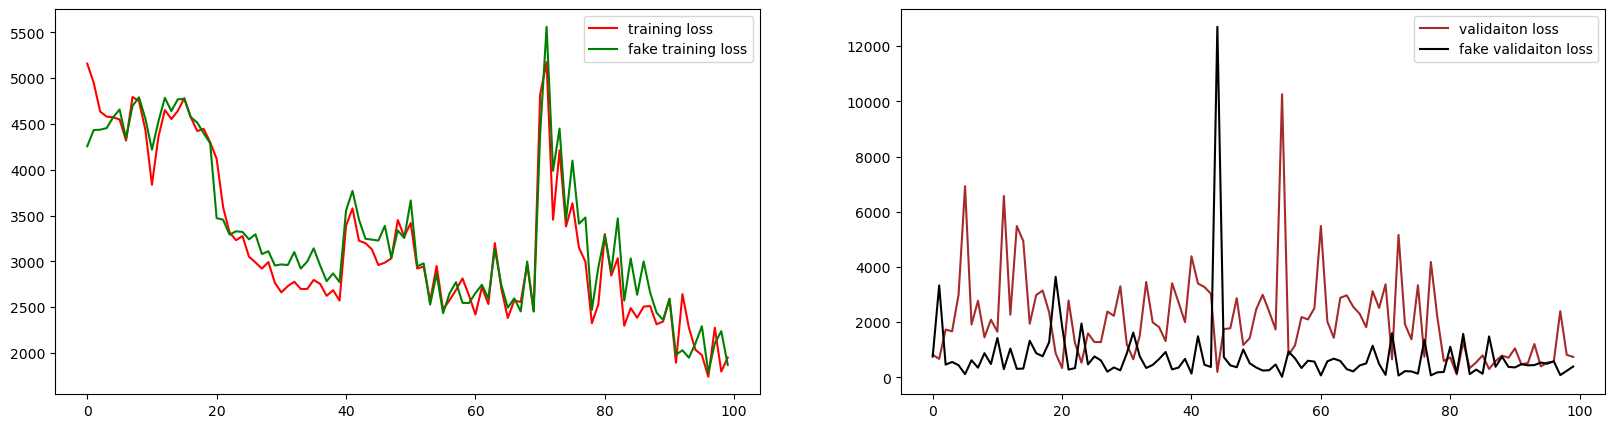

In [39]:
import matplotlib.patches as mpatches
epoch_list =list(range(len(training_losses[-100:])))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
training_loss_plot=ax.plot(epoch_list, training_losses[-100:],label='training loss',color='red')

fake_training_loss_plot=ax.plot(epoch_list, fake_train_losses[-100:],label='fake training loss',color='green')
# total_training_loss_plot=ax.plot(epoch_list, total_losses,label='total training loss',color='blue')
validation_losses_plot=ax2.plot(epoch_list, validation_losses[-100:],label='validaiton loss',color='brown')
fake_validation_losses_plot=ax2.plot(epoch_list, fake_validation_losses[-100:],label='fake validaiton loss',color='black')
# total_validation_losses_plot=ax2.plot(epoch_list, total_validation_losses,label='total validaiton loss',color='orange')
ax.legend(loc='upper right')
ax2.legend(loc='upper right')
torch
plt.show()

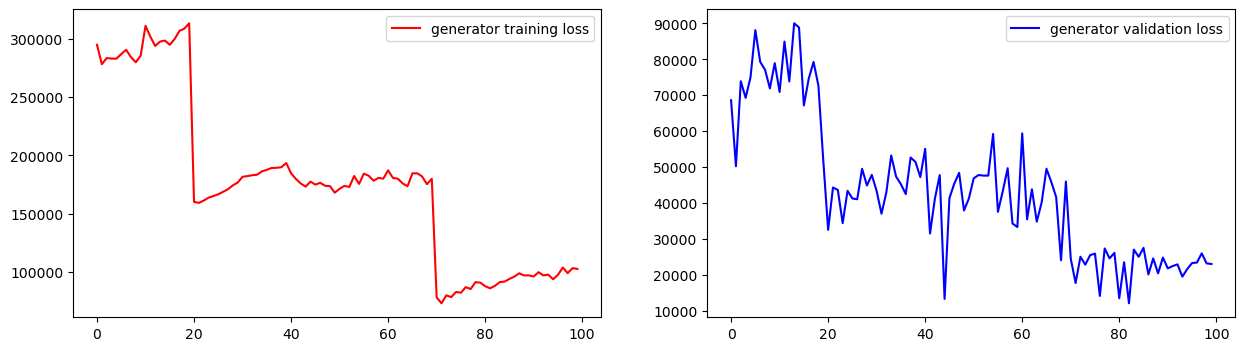

In [40]:

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
epoch_list =list(range(len(generating_losses[-100:])))
training_loss_plot=ax.plot(epoch_list, generating_losses[-100:],label='generator training loss',color='red')
validation_loss_plot=ax1.plot(epoch_list, generating_validation_losses[-100:],label='generator validation loss',color='blue')
ax.legend(loc='upper right')
ax1.legend(loc='upper right')

plt.show()

In [41]:
# for name, param in discriminator_model.named_parameters():
#     print(f"Layer: {name} | requires_grad: {param.requires_grad}")

# print("Optimizer param count:", len(optimizer_d.param_groups[0]['params']))
# for name, param in discriminator_model.named_parameters():
#     if param.grad is None:
#         print(f"Layer: {name} | Gradients: None (Check computation graph!)")
# for i, group in enumerate(optimizer_d.param_groups):
#     for j, p in enumerate(group['params']):
#         if p.grad is not None:
#             state = optimizer_d.state[p]
#             if 'exp_avg' in state:
#                 print(f"Param {j}: Momentum buffer (m_t) norm = {state['exp_avg'].norm().item()}")
#             if 'exp_avg_sq' in state:
#                 print(f"Param {j}: Variance buffer (v_t) norm = {state['exp_avg_sq'].norm().item()}")
# # print(optimizer_d.state_dict()['state'])
# for name, param in discriminator_model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

In [38]:
%%time
criterion= nn.BCELoss()
optimizer_d=optim.Adam(discriminator_model.parameters(),lr=0.0003,betas=(0.3, 0.995))
optimizer_g=optim.Adam(generator_model.parameters(),lr=0.0003, betas=(0.3, 0.99))
epochs=20
discriminator_loss_filename='discriminator_losses.txt'
generator_loss_filename='generator_losses.txt'

train(epochs,optimizer_d,optimizer_g,criterion,discriminator_model,generator_model,discriminator_loss_filename,generator_loss_filename )

training epoch:0
Gradients of discriminator parameter torch.Size([8, 3, 3, 3]): 6.399704456329346
Gradients of discriminator parameter torch.Size([8]): 6.011157035827637
Gradients of discriminator parameter torch.Size([16, 8, 3, 3]): 4.270675182342529
Gradients of discriminator parameter torch.Size([16]): 3.795147180557251
Gradients of discriminator parameter torch.Size([32, 16, 3, 3]): 2.9297268390655518
Gradients of discriminator parameter torch.Size([32]): 2.389305353164673
Gradients of discriminator parameter torch.Size([256, 2048]): 1.6610136032104492
Gradients of discriminator parameter torch.Size([256]): 0.7907129526138306
Gradients of discriminator parameter torch.Size([512, 256]): 0.11581537127494812
Gradients of discriminator parameter torch.Size([512]): 0.10339691489934921
Gradients of discriminator parameter torch.Size([1, 512]): 0.039150796830654144
Gradients of discriminator parameter torch.Size([1]): 0.014080841094255447
generator train loss reduced from:52626.296139 ==>

In [44]:
torch.save(generator_model.state_dict(), 'current_generator_model_latest.pth')
torch.save(discriminator_model.state_dict(), 'current_discriminator_model_latest.pth')

In [ ]:
# exit(0)

In [ ]:
random_vector = to_device(torch.randn(batch_size,latent_size,1,1).clamp(1,-1))
# print(random_vector)
fake_images = to_device(generator_model(random_vector))
# output = discriminator_model(fake_images)
# print(output)
# fake_labels  = to_device(torch.ones(batch_size,1))
discriminator_model.eval()
output = discriminator_model(fake_images)
print(output,fake_images.shape)
show_generated_images(fake_images.cpu())

for param in discriminator_model.parameters():
    if param.grad is not None:
        print(f'Gradients of discriminator parameter {param.shape}: {param.grad.norm()}')

In [ ]:

# for images,_ in valid_loader:    
#     output =discriminator_model(to_device(images))
#     print(output)
#     break

In [ ]:

# # output = discriminator_model(fake_images)
# # discriminator_model.state_dict()
# # output
# print(min_generating_loss)
# print(min_generating_training_loss)
# print(min_train_loss )

In [ ]:
# torch.ones(64,1)